place holder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os, sys
sys.path.append(os.path.abspath("../src"))

In [3]:
from data_pipeline.loaders import load_standardized_options, load_option_volume_wrds

px  = load_standardized_options("spy")
vol = load_option_volume_wrds("spy")

print("px cols:", px.columns.tolist()[:12])
print("vol cols:", vol.columns.tolist()[:12])


px cols: ['date', 'underlying', 'put_call', 'expiry', 'strike', 'mid', 'last', 'iv', 'delta', 'gamma', 'vega', 'theta']
vol cols: ['date', 'underlying', 'put_call', 'open_interest', 'volume']


All raw files present & materialized ✅
⚠️ SPY has many NaNs — verify source file/columns. Proceeding anyway.


/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline/io_utils.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.9:
/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline/io_utils.py:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  out["date"] = pd.to_datetime(out["date"], errors="coerce")
/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline/io_utils.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.9:
/Users/ya/Desktop/deep-hedging-rl/src/data_pipeline

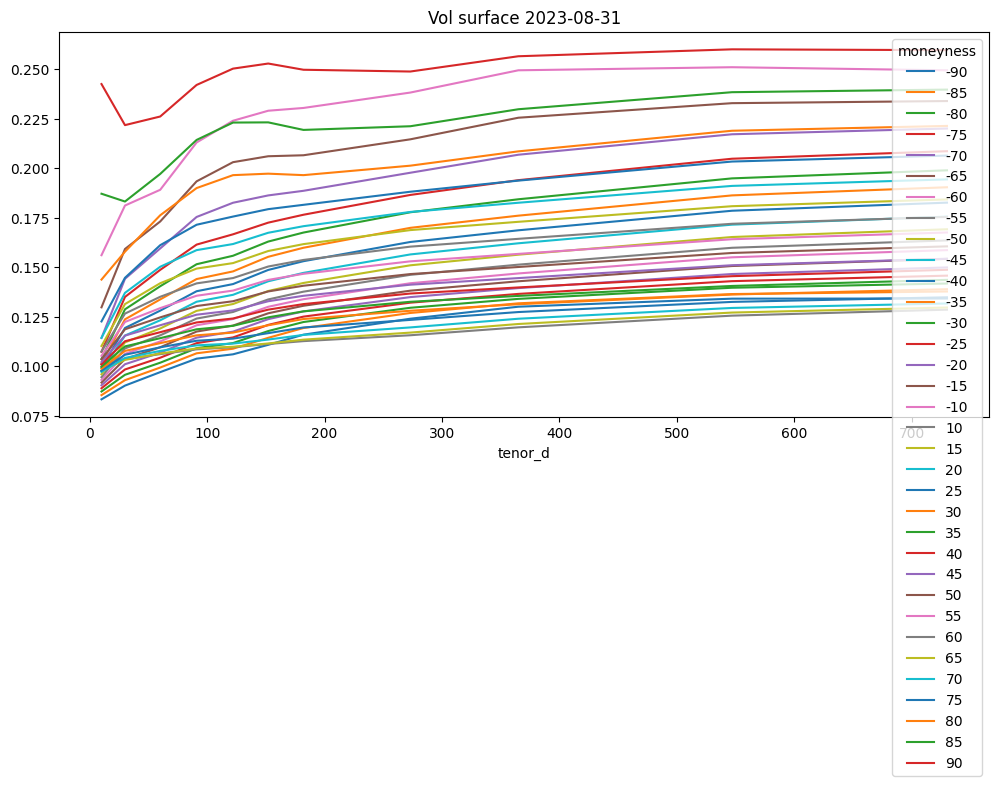

In [30]:
# 01_data_exploration.ipynb

# --- setup ---
import pandas as pd
import matplotlib.pyplot as plt

from data_pipeline.validate import validate_raw
from data_pipeline.builders import (
    build_market_daily,
    build_options_snapshot,
    build_vol_surface_long,
    build_market_plus_hvol_fwd,
)

# --- 0) check LFS files are materialized ---
validate_raw()   # will error if someone forgot `git lfs pull`

# --- 1) macro/market series ---
mkt = build_market_daily(save=False)
mkt.tail()

# --- 2) options snapshot (SPY) ---
opt_spy = build_options_snapshot("spy", save=False)
opt_spy.head()

# --- 3) vol surface (SPY) ---
surf_spy = build_vol_surface_long("spy", save=False)
surf_spy.head()

# pivot tenor vs moneyness for a date
d0 = surf_spy['date'].max()
surf0 = surf_spy.query("date == @d0").pivot(index='tenor_d', columns='moneyness', values='iv')
surf0.plot(title=f"Vol surface {d0.date()}", figsize=(12,5))
plt.show()


In [15]:
opt_spy

,date,underlying,put_call,expiry,strike,mid,last,iv,delta,gamma,vega,theta,open_interest,volume
0,2005-01-10,SPY,C,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,131377.0
1,2005-01-10,SPY,P,2005-01-20,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,109647.0
2,2005-01-10,SPY,C,2005-02-09,119.203780,1.622029,1.622029,0.119222,0.506618,0.097998,13.604388,-11.076229,0.0,131377.0
3,2005-01-10,SPY,P,2005-02-09,119.203780,1.651591,1.651591,0.120288,-0.499060,0.099202,13.573627,-8.884660,0.0,109647.0
4,2005-01-10,SPY,C,2005-03-11,119.479045,2.329275,2.329275,0.121075,0.509576,0.068224,19.235642,-8.500341,0.0,131377.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103241,2023-08-31,SPY,P,2024-08-30,470.293355,30.665202,30.665202,0.149578,-0.569648,0.008479,160.245994,-2.718230,14801715.0,4152975.0
103242,2023-08-31,SPY,C,2025-02-28,479.823396,34.368437,34.368437,0.160751,0.525911,0.004383,214.290135,-22.903168,6751654.0,3490295.0
103243,2023-08-31,SPY,P,2025-02-28,479.823396,40.379025,40.379025,0.155939,-0.589740,0.007348,189.943388,-0.864316,14801715.0,4152975.0
103244,2023-08-31,SPY,C,2025-08-30,486.964274,40.190556,40.190556,0.164426,0.528062,0.003675,245.306758,-20.561489,6751654.0,3490295.0


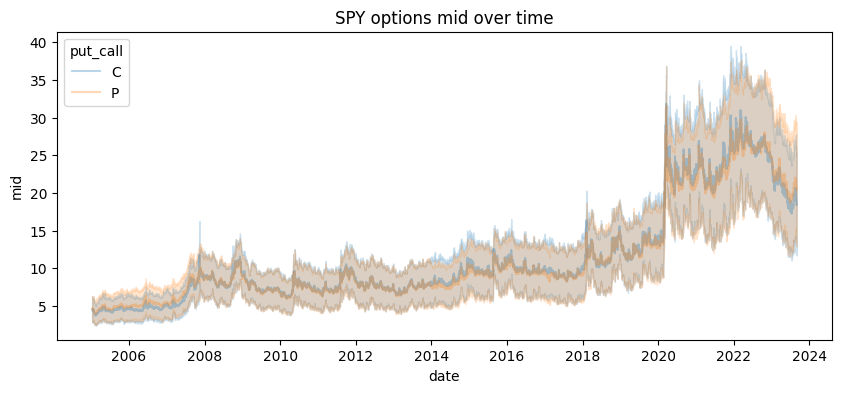

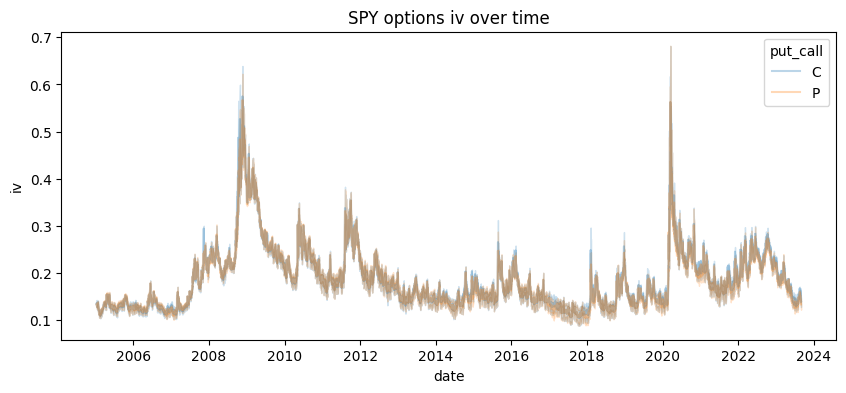

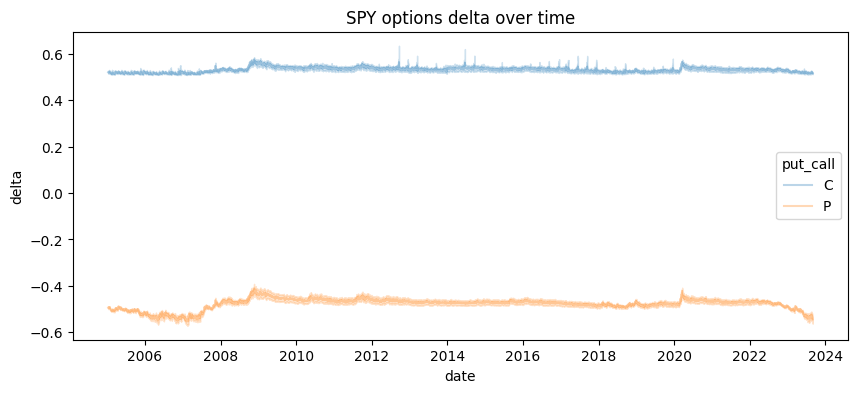

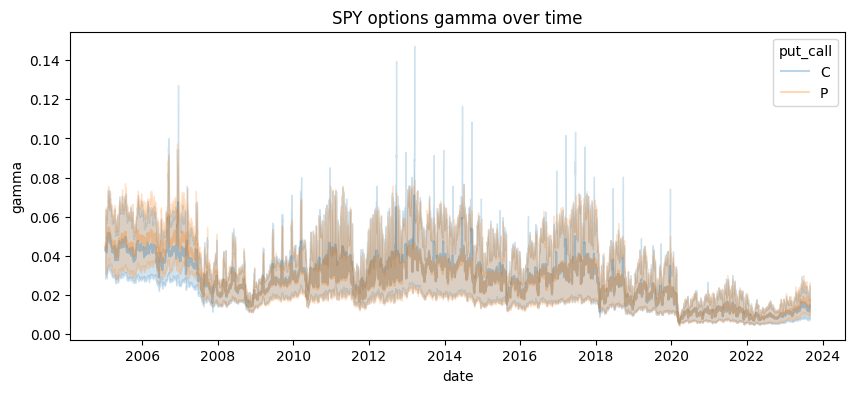

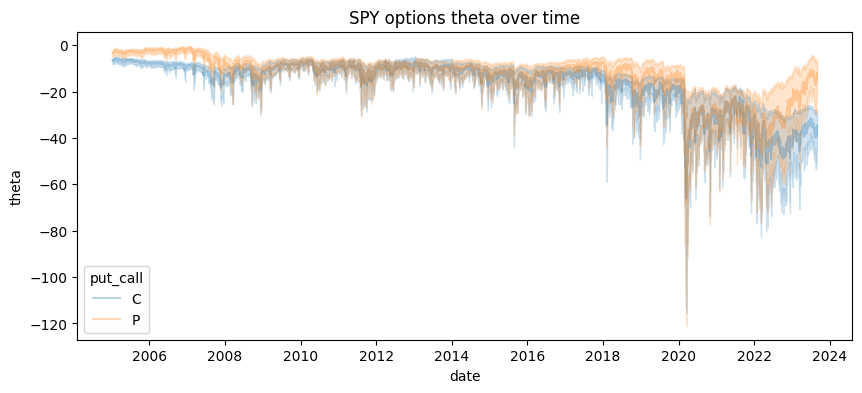

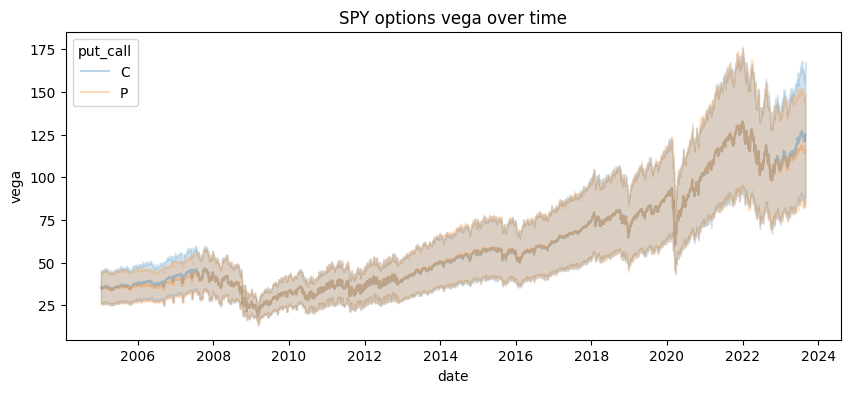

In [38]:
for col in ['mid', 'iv', 'delta', 'gamma', 'theta', 'vega']:
    plt.figure(figsize=(10,4))
    plt.title(f"SPY options {col} over time")
    sns.lineplot(data=opt_spy, x='date', y=col, hue='put_call', alpha=0.3)
    plt.show()


In [16]:
mkt

,close_spy,close_gspc,vix,rate_10y
date,,,,
1962-01-02,NaN,NaN,NaN,4.06
1962-01-03,NaN,NaN,NaN,4.03
1962-01-04,NaN,NaN,NaN,3.99
1962-01-05,NaN,NaN,NaN,4.02
1962-01-06,NaN,NaN,NaN,4.02
...,...,...,...,...
2025-09-21,NaN,NaN,15.45,4.14
2025-09-22,NaN,NaN,16.10,4.15
2025-09-23,NaN,NaN,16.64,4.12


In [23]:
# rows where at least one series has data
mkt_any = mkt[mkt.notna().any(axis=1)]

# rows where ALL 4 are present
mkt_all = mkt.dropna(subset=["close_spy","close_gspc","vix","rate_10y"])

# or start from the first valid SPY point
mkt_from_spy = mkt.loc[mkt["close_spy"].first_valid_index():]


,close_spy,close_gspc,vix,rate_10y
date,,,,
1996-01-04,36.771626,617.700012,13.78,5.65
1996-01-05,36.697166,616.710022,13.58,5.69
1996-01-06,36.697166,616.710022,13.58,5.69
1996-01-07,36.697166,616.710022,13.58,5.69
1996-01-08,36.836807,618.460022,13.11,5.68


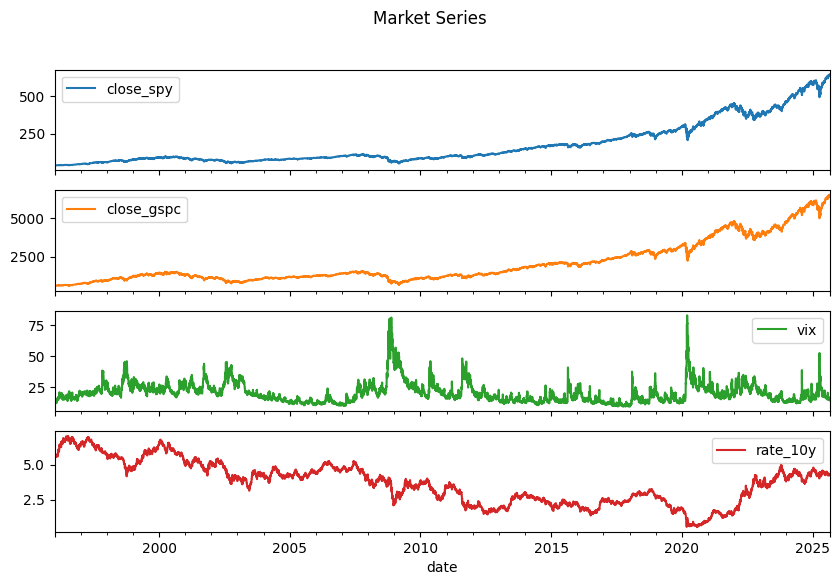

In [26]:
display(mkt_all.head())

mkt_all.plot(subplots=True, figsize=(10,6), title="Market Series")
plt.show()

In [17]:
surf_spy

,date,underlying,tenor_d,moneyness,iv
0,2005-01-10,SPY,30,-90,0.171916
1,2005-01-10,SPY,30,-85,0.142588
2,2005-01-10,SPY,30,-80,0.122542
3,2005-01-10,SPY,30,-75,0.116218
4,2005-01-10,SPY,30,-70,0.115786
...,...,...,...,...,...
1706455,2023-08-31,SPY,730,70,0.194336
1706456,2023-08-31,SPY,730,75,0.206330
1706457,2023-08-31,SPY,730,80,0.221290
1706458,2023-08-31,SPY,730,85,0.239605
